*italicized text*### Modeling

In [5]:
from platform import python_version
print(python_version())

3.7.13


In [6]:
import platform
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")

Computer network name: 3b583578aafd
Machine type: x86_64
Processor type: x86_64
Platform type: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
Operating system: Linux
Operating system release: 5.4.188+
Operating system version: #1 SMP Sun Apr 24 10:03:06 PDT 2022


In [7]:
import psutil
#Total RAM
print(f"Total RAM installed: {round(psutil.virtual_memory().total/1000000000, 2)} GB")
#Available RAM
print(f"Available RAM: {round(psutil.virtual_memory().available/1000000000, 2)} GB")
#Used RAM
print(f"Used RAM: {round(psutil.virtual_memory().used/1000000000, 2)} GB")
#RAM usage
print(f"RAM usage: {psutil.virtual_memory().percent}%")

Total RAM installed: 13.62 GB
Available RAM: 12.14 GB
Used RAM: 1.3 GB
RAM usage: 10.8%


several Neural Network architectures will be tested here

ANN AutoEncoder with single dense layer

ANN AutoEncoder with double dense layers

LSTM AutoEncoder with single reccurent layer

Stacked LSTM AutoEncoder with double reccurent layers

CNN-LSTM AutoEncoder with convolution layer to encode feature

Birectional-LSTM AutoEncoder with birectional-lstm layer in encoder and decoder architecture

### Importing nessesary libraries and modules

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
import pickle 
from sklearn.metrics import mean_absolute_error, accuracy_score
from tensorflow.compat.v1.keras.layers import Dense, TimeDistributed, CuDNNLSTM, RepeatVector, Conv1D, Bidirectional
from helpers import *

In [9]:
train_dataset = pd.read_csv("/content/trainingset1.csv", index_col=0)
val_dataset = pd.read_csv("/content/Validtionset1.csv", index_col=0)
test_dataset = pd.read_csv("/content/testset1.csv", index_col=0)

# New Section

In [10]:
train_dataset.head()

,a6,a7,a8,label
a1,,,,
1,0.38,0.00,0,1
2,0.67,0.00,0,1
3,0.45,0.00,0,1
4,0.48,0.17,1,1
5,0.20,0.17,1,1


In [11]:
train_dataset.isnull().any()

a6       False
a7       False
a8       False
label    False
dtype: bool

### Transforming the dataset

##### droping lable(last column) and changing data in to numpy arrays

In [12]:
X_train = np.array(train_dataset.drop(columns=['label']))
print(X_train.shape)

(838861, 3)


### Split test and validation dataset to feature and label sets

In [13]:
X_val, y_val = np.array(val_dataset.drop(columns=['label'])), np.array(val_dataset['label'])
X_test, y_test = np.array(test_dataset.drop(columns=['label'])), np.array(test_dataset['label'])

print(X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(754976, 3) (754976,) (2000, 3) (2000,)


In [14]:
X_train = np.array(train_dataset.drop(columns=['label']))
print(X_train.shape)

(838861, 3)


In [15]:
X_train_3d=tf.convert_to_tensor(X_train ,dtype=tf.float32)
print(X_train_3d)

tf.Tensor(
[[0.38 0.   0.  ]
 [0.67 0.   0.  ]
 [0.45 0.   0.  ]
 ...
 [0.82 0.5  1.  ]
 [2.33 1.17 1.  ]
 [1.68 0.   0.  ]], shape=(838861, 3), dtype=float32)


In [16]:
X_val_3d=tf.convert_to_tensor(X_val ,dtype=tf.float32)
print(X_val_3d)

tf.Tensor(
[[0.33 0.   0.  ]
 [4.77 2.5  1.  ]
 [0.57 0.33 1.  ]
 ...
 [0.82 0.5  1.  ]
 [2.33 1.17 1.  ]
 [1.68 0.   0.  ]], shape=(754976, 3), dtype=float32)


In [17]:
X_test_3d=tf.convert_to_tensor(X_test ,dtype=tf.float32)
print(X_test_3d)

tf.Tensor(
[[0.73333335 0.3496     1.        ]
 [0.3        0.1748     1.        ]
 [0.13333334 0.1748     1.        ]
 ...
 [1.2833333  0.         0.        ]
 [1.1        0.5244     1.        ]
 [1.0166667  0.5244     1.        ]], shape=(2000, 3), dtype=float32)


### Reshape feature set to desire format for LSTM (3d array)

In [18]:
# reshapeing to [num samples, num timesteps, num features]
X_train_3d = X_train.reshape(*X_train.shape,1)
X_val_3d = X_val.reshape(*X_val.shape,1)
X_test_3d = X_test.reshape(*X_test.shape,1)

print(X_train_3d.shape, X_test_3d.shape)

(838861, 3, 1) (2000, 3, 1)


## Model training

 heartbeat sequence from the train set will be used as input and output for AutoEncoders. the reconstruction loss on training data will be recorded and then the validation set will be used to set the treshhold which will result in highest accuracy. The accuracy on the test set will be calculated and choose examples to show how well AutoEncoders can reproduce the input sequence.

### Specifing training conditions

In [19]:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=0,
    verbose=1,
    patience=10,
    mode='min',
    baseline=None,
    restore_best_weights=True)

EPOCHS = 20
BATCH_SIZE = 32

# placeholder of predition metrics
results = Metrics()

### **LSTM AutoEncoder**

## **Building the model** 

In [20]:
# Build model
model = Sequential()
model.add(CuDNNLSTM(64, input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train.shape[1]) )
model.add(CuDNNLSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 64)                17152     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 3, 64)             33280     
                                                                 
 time_distributed (TimeDistr  (None, 3, 1)             65        
 ibuted)                                                         
                                                                 
Total params: 50,497
Trainable params: 50,497
Non-trainable params: 0
_________________________________________________________________


 ## **Fit the model**

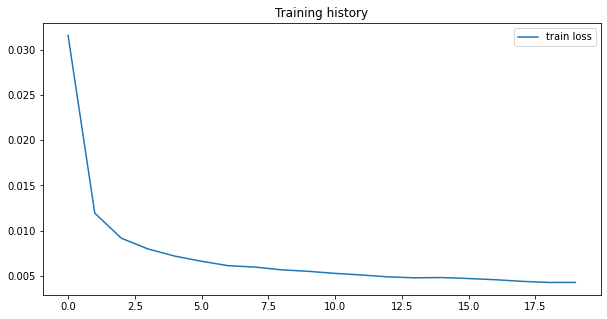

In [21]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING])

### **Makeing predictions and calculating reconstruction error for each dataset**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


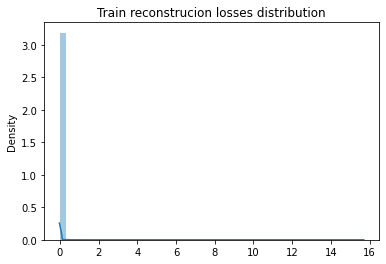

In [22]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True);

###**Selecting threshold for maximum accuracy** 

In [23]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0043 Validation Accuracy: 0.8974
Perentile:91 Threshold: 0.0044 Validation Accuracy: 0.9069
Perentile:92 Threshold: 0.0045 Validation Accuracy: 0.9174
Perentile:93 Threshold: 0.0046 Validation Accuracy: 0.927
Perentile:94 Threshold: 0.0058 Validation Accuracy: 0.9375
Perentile:95 Threshold: 0.0075 Validation Accuracy: 0.9479
Perentile:96 Threshold: 0.0092 Validation Accuracy: 0.9582
Perentile:97 Threshold: 0.0135 Validation Accuracy: 0.9685
Perentile:98 Threshold: 0.0232 Validation Accuracy: 0.979
Perentile:99 Threshold: 0.0435 Validation Accuracy: 0.9894
-----------------------------------------------------------------
Best validation accuracy: 0.9894 for threshold: 0.0435


**Calculating prediction metrics and adding them to a placeholder**

In [24]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

Test accuracy score: 0.944
Test precision score: 0.944
Test recall score: 1.0
Test f1 score: 0.9712


### **visualization for correctly predicted class**

ValueError: ignored

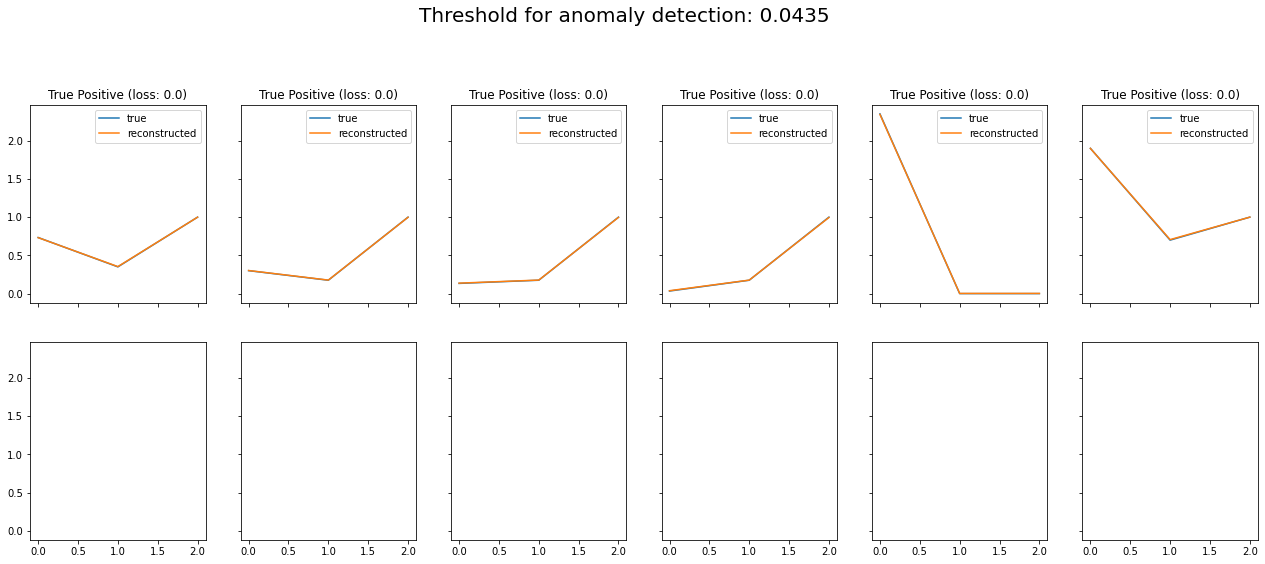

In [25]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

Point : LSTM AutoEncoder learned some pattern from training data (an additional peak at the end of the sequence) and tries to recreate it in each sequence - it's easy to see on the anomaly plots.

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [26]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

<Figure size 1584x576 with 0 Axes>

### **Saving the model for future**

In [27]:
model.save('LSTM_AutoEncoder.h5')

### **Stacked LSTM AutoEncoder**

## **Building the model** 

In [28]:
# Build model
model = Sequential()
model.add(CuDNNLSTM(64, input_shape=(X_train_3d.shape[1:]), return_sequences=True))
model.add(CuDNNLSTM(64))
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(CuDNNLSTM(64, return_sequences=True))
model.add(CuDNNLSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 3, 64)             17152     
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 64)                33280     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 3, 64)            0         
 or)                                                             
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 3, 64)             33280     
                                                                 
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 3, 64)             33280     
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 1)             65        
 tributed)                                            

 ## **Fit the model**

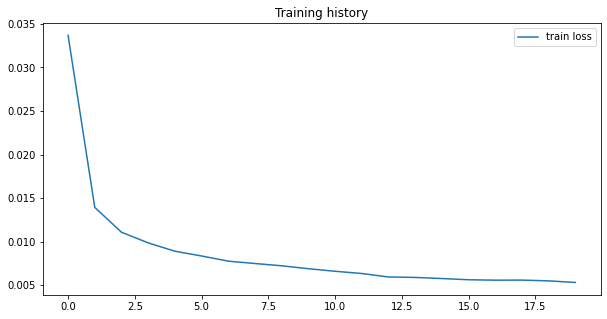

In [29]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

### **Makeing predictions and calculating reconstruction error for each dataset**

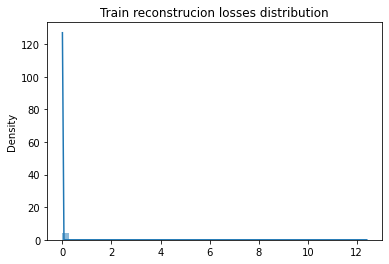

In [30]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.histplot(train_loss, bins=50, kde=True, stat="density", linewidth=0);

###**Selecting threshold for maximum accuracy** 

In [31]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0041 Validation Accuracy: 0.897
Perentile:91 Threshold: 0.0055 Validation Accuracy: 0.9071
Perentile:92 Threshold: 0.0065 Validation Accuracy: 0.9167
Perentile:93 Threshold: 0.0084 Validation Accuracy: 0.9275
Perentile:94 Threshold: 0.01 Validation Accuracy: 0.9378
Perentile:95 Threshold: 0.0122 Validation Accuracy: 0.948
Perentile:96 Threshold: 0.0135 Validation Accuracy: 0.9582
Perentile:97 Threshold: 0.0197 Validation Accuracy: 0.9686
Perentile:98 Threshold: 0.0264 Validation Accuracy: 0.979
Perentile:99 Threshold: 0.0309 Validation Accuracy: 0.9894
-----------------------------------------------------------------
Best validation accuracy: 0.9894 for threshold: 0.0309


**Calculating prediction metrics and adding them to a placeholder**:

In [32]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Stacked LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

Test accuracy score: 0.951
Test precision score: 0.951
Test recall score: 1.0
Test f1 score: 0.9749


### **visualization for correctly predicted class**

ValueError: ignored

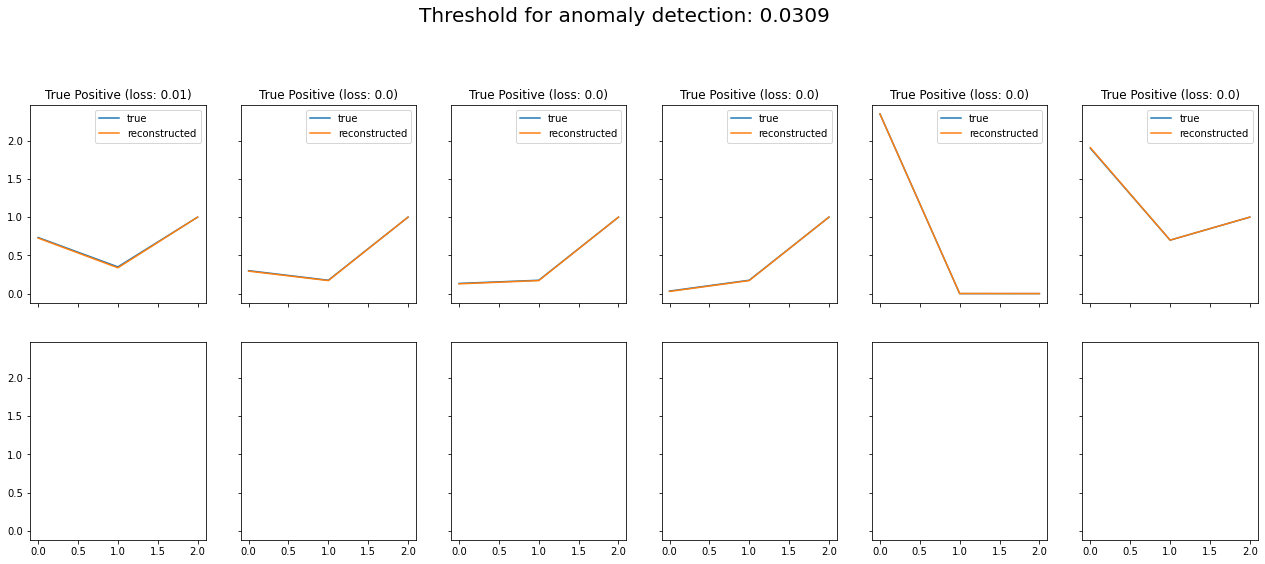

In [34]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [35]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

<Figure size 1584x576 with 0 Axes>

### **Saving the model for future**

In [36]:
model.save('Stacked_LSTM_AutoEncoder.h5')

### **Bidirectional LSTM AutoEncoder**

## **Building the model** 

In [37]:
# Build model
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(64), input_shape=(X_train_3d.shape[1:]) ) )
model.add(RepeatVector(X_train_3d.shape[1]))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True) ) )
model.add(TimeDistributed(Dense(1)) )
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              34304     
 l)                                                              
                                                                 
 repeat_vector_2 (RepeatVect  (None, 3, 128)           0         
 or)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 128)           99328     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 3, 1)             129       
 tributed)                                                       
                                                                 
Total params: 133,761
Trainable params: 133,761
Non-tr

 ## **Fit the model**

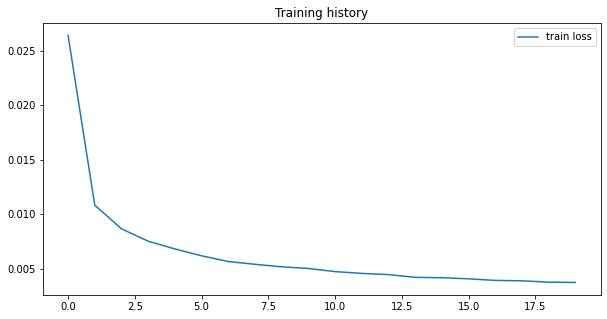

In [38]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

### **Makeing predictions and calculating reconstruction error for each dataset**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


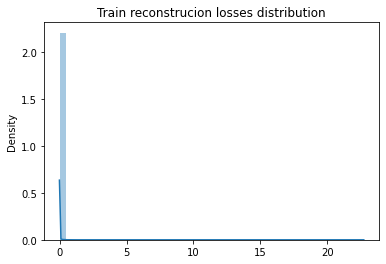

In [39]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.distplot(train_loss, bins=50, kde=True);

###**Selecting threshold for maximum accuracy** 

In [40]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

Perentile:90 Threshold: 0.0023 Validation Accuracy: 0.8968
Perentile:91 Threshold: 0.0025 Validation Accuracy: 0.907
Perentile:92 Threshold: 0.0028 Validation Accuracy: 0.9172
Perentile:93 Threshold: 0.0033 Validation Accuracy: 0.9273
Perentile:94 Threshold: 0.0042 Validation Accuracy: 0.9375
Perentile:95 Threshold: 0.0055 Validation Accuracy: 0.9478
Perentile:96 Threshold: 0.0075 Validation Accuracy: 0.9583
Perentile:97 Threshold: 0.0109 Validation Accuracy: 0.9686
Perentile:98 Threshold: 0.0158 Validation Accuracy: 0.979
Perentile:99 Threshold: 0.0283 Validation Accuracy: 0.9894
-----------------------------------------------------------------
Best validation accuracy: 0.9894 for threshold: 0.0283


**Calculating prediction metrics and adding them to a placeholder**:

In [41]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Bidirectional LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

Test accuracy score: 0.953
Test precision score: 0.953
Test recall score: 1.0
Test f1 score: 0.9759


### **visualization for correctly predicted class**

ValueError: ignored

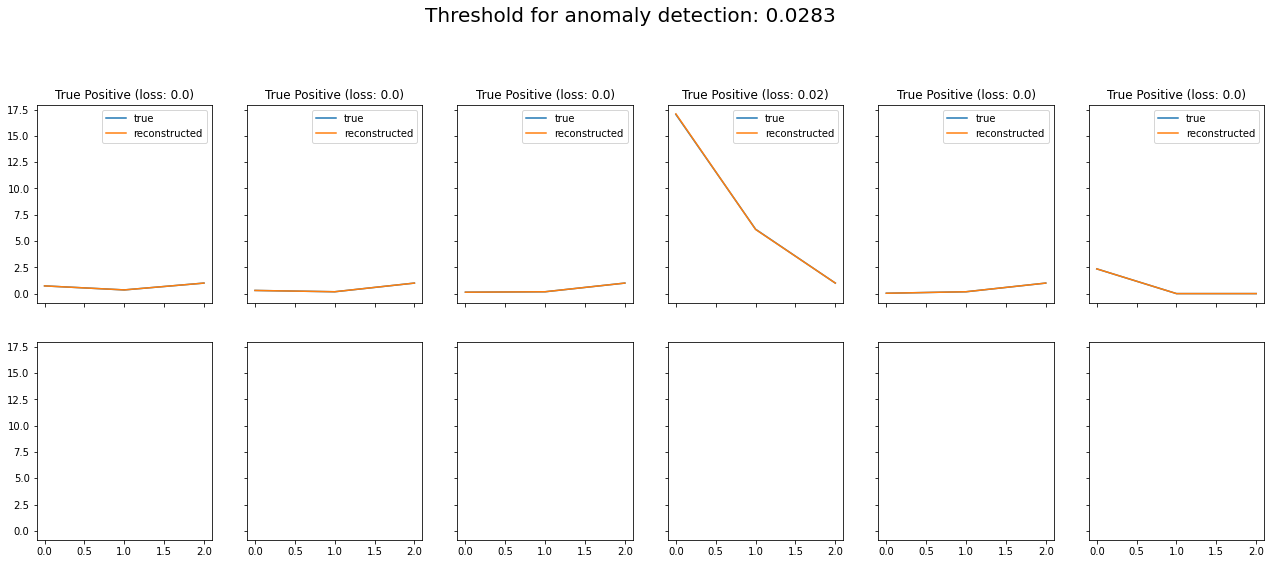

In [42]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

Point : Bidirectional LSTM AutoEncoder isn't good solution for this problem. the model learned that in normal heartbeats occur a sigificant drops and extra peaks at the begininng and at the end of sequence.

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [ ]:
# incorrectly classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

Point : The Bidirectional LSTM AutoEncoder made mistake on relatively easy sequences

### **Saving the model for future**

In [ ]:
model.save('Bidirectional_LSTM_AutoEncoder.h5')

### **CNN LSTM AutoEncoder**

## **Building the model** 

In [ ]:
# Build model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_3d.shape[1:]) ) ) 
model.add(CuDNNLSTM(64) )
model.add(RepeatVector(X_train_3d.shape[1]) )
model.add(CuDNNLSTM(64, return_sequences=True) )
model.add(TimeDistributed(Dense(1) ) )
model.compile(loss='mae', optimizer='adam')
model.summary()

 ## **Fit the model**

In [ ]:
fit_model(model, X_train_3d, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

### **Makeing predictions and calculating reconstruction error for each dataset**

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train_3d, X_val_3d, X_test_3d)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train_3d, X_train_pred, 
                                                                 X_val_3d, X_val_pred,
                                                                 X_test_3d, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.histplot(train_loss, bins=50, kde=True, stat="density", linewidth=0);

###**Selecting threshold for maximum accuracy** 

In [ ]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

**Calculating prediction metrics and adding them to a placeholder**

In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('CNN LSTM AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

### **visualization for correctly predicted class**

In [ ]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test_3d[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

Point : As you can see, CNN LSTM AutoEncoder learned the same pattern as LSTM AutoEncoders - an additional peak at the end of the sequence, and also remembered a significant decrease at the beginning of the sequence.

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [ ]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test_3d[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test_3d[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

Point : The CNN LSTM AutoEncoder misclassified the same sequences as Stacked LSTM AutoEncoders

### **Saving the model for future**

In [ ]:
model.save('CNN_LSTM_AutoEncoder.h5')

### **ANN with single layer AutoEncoder**

## **Building the model** 

In [ ]:
model = Sequential()
model.add(Dense(units=64, input_shape=(X_train.shape[1:]), activation='relu') )
model.add(Dense(units=32) )
model.add(Dense(units=64, activation='relu') )
model.add(Dense(units=X_train.shape[1]) )
model.compile(loss='mae', optimizer='adam')
model.summary()

## **Fit the model**

In [ ]:
fit_model(model, X_train, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

### **Makeing predictions and calculating reconstruction error for each dataset**

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train, X_val, X_test)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train, X_train_pred, 
                                                                 X_val, X_val_pred,
                                                                 X_test, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.histplot(train_loss, bins=50, kde=True, stat="density", linewidth=0);

###**Selecting threshold for maximum accuracy** 

In [ ]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

**Calculating prediction metrics and adding them to a placeholder**

In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('ANN AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

### **visualization for correctly predicted class**

In [ ]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

Point : As you can see ANN AutoEncoder tries to remember whole sequences, doesn't try to find any paterns to detect anomalies

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [ ]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

Poinit : The second and third bottom samples look like a normal heartbeat, mayby were incorrect labeled?

### **Saving the model for future**

In [ ]:
model.save('ANN_AutoEncoder.h5')

### **Stacked ANN AutoEncoder with two dense layers**

## **Building the model** 

In [ ]:
model = Sequential()
model.add(Dense(units=64, input_shape=(X_train.shape[1:]), activation='relu') )
model.add(Dense(units=64, activation='relu') )
model.add(Dense(units=32) )
model.add(Dense(units=64, activation='relu') )
model.add(Dense(units=64, activation='relu') )
model.add(Dense(units=X_train.shape[1]) )
model.compile(loss='mae', optimizer='adam')
model.summary()

## **Fit the model**

In [ ]:
fit_model(model, X_train, EPOCHS, BATCH_SIZE, verbose=0, callbacks=[EARLY_STOPPING]);

### **Making predictions and calculating reconstruction error for each dataset**

In [ ]:
# make predictions (reconstructions) for each dataset
X_train_pred, X_val_pred, X_test_pred = make_predictions(model, X_train, X_val, X_test)

# calculate reconstructions losses for each dataset
train_loss, val_loss, test_loss = calculate_reconstrucion_losses(X_train, X_train_pred, 
                                                                 X_val, X_val_pred,
                                                                 X_test, X_test_pred)

# show train reconstrucion losses distribution
plt.title('Train reconstrucion losses distribution')
sns.histplot(train_loss, bins=50, kde=True, stat="density", linewidth=0);

###**Selecting threshold for maximum accuracy** 

In [ ]:
# define percentile range for tesing threshold
percentiles = range(90,100)

threshold = select_threshold(train_loss, y_val, val_loss, percentiles)

**Calculating prediction metrics and adding them to a placeholder**

In [ ]:
# predict test set classes based on test reconctrucion losses and selected threshold
y_test_pred = [int(x < threshold) for x in test_loss]

# calculate and print predicion metrics
test_accuracy, test_precision, test_recall, test_f1_score = calculate_prediction_metrics(y_test, y_test_pred, verbose=1)

# add prediction metrics to place holder
results.add_components('Stacked ANN AutoEncoder', X_test_pred, y_test_pred, test_accuracy, test_precision, test_recall, test_f1_score)

### **visualization for correctly predicted class**

In [ ]:
# corrected classified normal and anomaly sequences   
X_test_normal = X_test[(y_test==1)  & (np.array(y_test_pred)==1)]
X_test_anomaly = X_test[(y_test==0) & (np.array(y_test_pred)==0)]

# print sequences
plot_recontructions(model,
                    X_test_normal,
                    X_test_anomaly,
                    threshold,
                    'True Positive',
                    'True Negative',
                    nrows=2,
                    ncols=6,
                    figsize=(22, 8) )

Point : As you can see Stacked ANN AutoEncoder like ANN AutoEncoder tries to remember whole sequences, doesn't try to find any patern to detect anomalies.

### **visualization for incorrectly predicted/classified normal and anomaly sequences**

In [ ]:
# incorrected classified normal and anomaly sequences   
X_test_normal_classified_as_anomaly = X_test[(y_test==1)  & (np.array(y_test_pred)==0)]
X_test_anomaly_classified_as_normal = X_test[(y_test==0) & (np.array(y_test_pred)==1)]

# if the number of incorrectly classified samples in at least one case is less than 6
ncols = np.min([len(X_test_normal_classified_as_anomaly), 
                len(X_test_anomaly_classified_as_normal), 
                6])

# print sequences
plot_recontructions(model,
                    X_test_normal_classified_as_anomaly,
                    X_test_anomaly_classified_as_normal,
                    threshold,
                    'False Positive',
                    'False Negative',
                    nrows=2,
                    ncols=ncols,
                    figsize=(22, 8) )

Point : Three middle bottom samples look like a incorrect labeled.

### **Saving the model for future**

In [ ]:
model.save('Stacked_ANN_AutoEncoder.h5')

### **compiled results summary report**

---



In [ ]:
# get prediction metric result lists from placeholder
precision_score, recall_score, f1_score, accuracy_score = results.get_metrics()

# get model names list from placeholder
models_name = results.get_names()

# create dictionary of results 
results_dict = {'precision_score': precision_score, 
               'recall_score': recall_score, 
               'f1_score': f1_score,
               'accuracy_score' : accuracy_score}

results_df = pd.DataFrame(data=results_dict)
results_df.insert(loc=0, column='Model', value=models_name)
results_df

In [ ]:
# save metrics
results_df.to_csv('final_results.csv')

# save model names
with open('models_name.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(models_name, f, pickle.HIGHEST_PROTOCOL)

# extract reconstructed test sequences and predictions from placeholder
test_sequences, test_predictions = results.get_test_predictions()

# save test sequences
with open('test_sequences.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_sequences, f, pickle.HIGHEST_PROTOCOL)

# save test predictions
with open('test_predictions.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(test_predictions, f, pickle.HIGHEST_PROTOCOL)